# scikit-learn: Classification - 2
 >__Created__:  2018 Harrison B. Prosper


## Introduction
We consider the benchmark task of classifying the $28 \times 28 = 784$ gray scale pixel images of handwritten digits in the MNIST data set using __supervised learning__. In supervised learning a model is trained (that is, fitted) to data consisting of unambiguously labeled __feature vectors__, here images. For classification the label is the class to which a vector belongs, while for regression the labels are the values associated with the vectors. In the MNIST data set there are $K = 10$ classes, labeled by the digits 0 to 9. The data contains $T = 60,000$ images for training and 10,000 images for testing. Following good practice, we split the training data into a set for training and another for validating the training. The test data are not used in the training.

The value of each pixel in the MNIST data set lies in the discrete set $[0, 1, \cdots, 255]$. Again, following good practice, we rescale each datum so that it lies in the unit interval. In this exercise, the data lie in the (rational) set $D = [0, 1/255, \cdots, 1]$. The MNIST training data is to be thought of as a sample from some unknown probability distribution $p(t, x)$ defined on the finite discrete space $[0,\cdots,9] \times D^{784}$, where the __target__, $t$, is the class label associated with image $x$. ($p(t, x)$ is clearly an abstraction since it is the distribution of an infinite MNIST data set that exists only in the same sense as the set of real numbers.) An image can be conceptualized as a point $x \in D^{784}$. If we associate each class with a different color, the training data form a swarm of colored points where points of a given color tend to "flock" together.

In this exercise, a fully connected shallow neural network (SNN) is used to classify the MNIST digits. The training is done with __batches__ of images represented by a 2-index tensor $\mathbf{x}_{nj}$ of __shape__ $(N, H \times W)$, i.e., a matrix. The first index (along dimension dim = 0) labels the ordinal value $n$ of an image in a batch of $N$ images, while the second index (along dim = 1) labels the pixels of a *flattened* image of height and width $H$ and $W$, respectively.  

### Model
Machine learning models often have an aura of mystery about them. But, a sensible perspective can be maintained by remembering that regardless of how their form may have been motivated, these models are, ultimately, just exceedingly complicated non-linear functions. 

Another point should be noted before we delve into details. Much has been made of the sometimes spectacular failure in the application of machine learning to real-world problems. For example, suppose that a single pixel in an image is changed, say from the value 197/255 to the value 0. This causes the point representing the image in the space $D^{784}$ to suffer a displacement in that space. To the human brain, a single pixel change in a $28 \times 28$ image is a negligible distortion that does not impair its ability to classify the image, either because the distortion goes unnoticed or it is ignored. But, to a machine learned classifier, a single pixel change could result in a large displacement in the abstract space of images, thereby making the image an outlier whose position is no longer representative of the distribution of *any* of the classes defined by the probability $p(t, x)$. The point is that the classifier depends on the probability $p(t, x)$, therefore, if the latter fails to capture the kinds of outliers one expects in real-world data, it ought not to surprise that the classifier may fail to classify an outlier correctly. 

One might think that the solution is to train with data that contains outliers. However, it may not be feasible to build a model that captures every sort of potential outlier. Moreover, if outliers in the training data are relatively rare, the training procedure may simply ignore them. A more practical approach might be to devise a way to recognize when an image is an outlier, detect which subsets of pixels are responsible for this and assign to the offending pixels values that are representative of their neighborhood. Having tamed the image in this way, it is then presented to the classifier.

In this exercise, we use the following model 

$$\mathbf{y} = \mbox{softmax}(\,\mathbf{b}_1 + \mathbf{w}_1 \, \mbox{relu}(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}) \, ),$$

where $\mathbf{b}$ and $\mathbf{w}$, the biases and weights, are the parameters of the model and $\mbox{relu}(x)$, which is applied to every element $x$ of its tensor argument (i.e., applied element-wise), is defined by

\begin{align*}
\mbox{relu}(x) & = \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}

The parameters with suffix 0 pertain to the input layer, while those with suffix 1 pertain to the so-called __hidden__ layer.
Since $\mathbf{y}$ models class probabilities that sum to unity, it makes sense to map each output of the hidden layer to the unit interval by applying, for example, the softmax function for $K$ output classes, 

\begin{align*}
(\mbox{softmax}(x))_k & = \frac{\exp(x_{(k)})}{\sum_{j=0}^{K-1} \exp(x_{(j)})} ,
\end{align*}

where $x_{(k)}$ denotes the $k^\mbox{th}$ output of the hidden layer. 

### Loss function
Typically, a machine learning model is fitted to the training data by minimizing a suitably defined function, which in the statistics literature is often referred to as the __empirical risk__. (Fitting models to data is called learning by machine learning enthusiasts.) The empirical risk is a Monte Carlo approximation of the __risk functional__, defined by 

\begin{align*}
    R[f] &= \int L(t, \, f(x, \theta)) \, 
    p(t, \, x) \, dt \, dx,
\end{align*}

where $L(t, \, f)$ is called the __loss function__ and measures how much one loses if the output of the parameterized function $f(x, \theta)$ differs from the __target__ $t$. $\color{blue}{\rm Warning}$: In the machine learning world, the empirical risk is typicaly referred to as the loss function, when what is really meant is the average loss function. 

__Important Note__: In order for the risk functional $R[f]$ to reach its minimum, defined by variations of $f$ that yield the condition $\delta R = 0$ for all $x$, the function $f$ must be sufficiently flexible. If the latter condition is satisfied, then the mathematical quantity approximated by $f$ depends solely on the form of the loss function $L(t, \, f)$ and the probability distribution $p(t, \, x)$ of the training data. In particular, it does not depend on
    the details of the functon $f$ apart from its presumed flexibility. Of course, in practice, we do not minimize $R[f]$, but rather the empirical risk, which is an approximation to it. Nevertheless, to the degree that a very large data set approximates an infinite one and to the degree that our minimizer is able to find a good minimum, this note suggests it is as least as important to think about the form of the loss function $L(t, \, f)$ as it is to think about the form of the model. After all, if we have two models of equal functional flexibility, *a priori*, for the same loss function thet will approximate the same quantity. 

In order to motivate our choice of loss function, we start with the __Kullback-Leibler__ (KL) divergence

\begin{align*}
    D(p || q) & = \sum_i p_i \log(p_i / q_i),
\end{align*}

which is a *global* measure of the dissimilarity between a probability distribution $p$ and a reference distribution $q$. The KL divergence is a global measure in that it depends on the entire probability distributions $p$ and $q$. In particular, the measure does not supply information about where $p$ and $q$ are well matched and where they are not. 

The KL divergence is zero if and only if the two distributions are identical. Typically, we have a model for $q$, but $p$ is usually unknown, which makes it difficult to approximate $D(p || q)$. However, the KL divergence can be written as,

\begin{align*}
  D(p || q) & = \sum_i p_i \log(p_i / q_i),\\
            & = -\sum_i p_i \log q_i - \left(-\sum_i p_i \log p_i\right),\\
            & = H(p, q) - H(p).
\end{align*}

The quantity $H(p) = -\sum_i p_i \log p_i$ is called the __entropy__, while $H(p, q)$ is called the __cross entropy__. Like the KL divergence, the cross entropy is minimized when $q = p$, whereupon it equals the entropy of the probability distribution $p$. The practical advantage of the cross entropy over the KL divergence is that for training data distributed according to $p$, we can use the following Monte Carlo approximation of the cross entropy,

\begin{align*}
  H(p, q) & = -\sum_i p_i \log q_i,\\
            & \approx -\frac{1}{T}\sum_{i=0}^{T-1} \log q_i,
\end{align*}

where $T$ is the number of feature vectors, here images, in the training set. In this exercise, we shall use cross entropy as the loss function.
The outputs of the model are the conditional class probabilities

\begin{align*}
    P(k \, | \, \mathbf{x} ) & = \frac{P(\mathbf{x} \, | \, k) \, \pi(k)}{\sum_{j=0}^K P(\mathbf{x} \, | \, j) \, \pi(j)},
\end{align*}

where $\pi(k)$ is the prior probability of class $k$ and $P(\mathbf{x} \, | \, k)$ is the probability of image $\mathbf{x}$ *given* that it is of class $k$. ($P(\mathbf{x} \, | \, k)$ is often referred to as the __likelihood__.) To compute the loss function, we set $q_i = P(k_i \, | \, \mathbf{x}_i )$, where $k_i$ is the true class index of image $x_i$. In other words, we take $q_i$ to be the estimated conditional probability that image $x_i$ is of class $k_i$ given that it is known to be of that class.

### Exercise
  1. Build deep network, using __MLPClassifier__, to classifier handwritten digits from the MNIST database 
  1. Try one and two hidden layers.
  1. Vary the number of nodes/layer

In [1]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

import joblib as jb
import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 16
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}

mp.rc('font', **font)

### Load MNIST data 


In [4]:
train_x, train_y = jb.load('../datasets/mnist_train.pkl')
test_x,  test_y  = jb.load('../datasets/mnist_test.pkl')

### Plot a selection of images from the training data

In [5]:
def plotImages(x, n_rows=2, n_cols=5, f_size=(10, 4)):
    f, ax = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=f_size)
    
    for image, ax in zip(x, ax.flatten()):
        ax.imshow(image.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

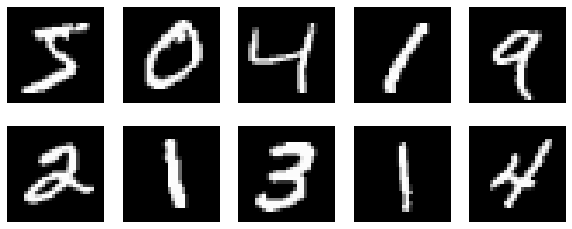

In [6]:
plotImages(train_x)

### Train classifier

In [8]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100), 
                    max_iter=1000, 
                    alpha=1e-2,
                    solver='adam', 
                    verbose=1, 
                    tol=1e-6, 
                    warm_start=False,
                    random_state=1)

print("*** TRAINING ***")
mlp.fit(train_x, train_y)

print("Training set score: %f" % mlp.score(train_x, train_y))      
print("Test set score:     %f" % mlp.score(test_x,  test_y))

filename = 'mnist_scikit_snn.pkl'
print("save to %s" % filename)
jb.dump(mlp, filename)

*** TRAINING ***
Iteration 1, loss = 0.40732814
Iteration 2, loss = 0.16113032
Iteration 3, loss = 0.11865388
Iteration 4, loss = 0.09465947
Iteration 5, loss = 0.08134931
Iteration 6, loss = 0.06974821
Iteration 7, loss = 0.06211915
Iteration 8, loss = 0.05386695
Iteration 9, loss = 0.04940621
Iteration 10, loss = 0.04579688
Iteration 11, loss = 0.04139810
Iteration 12, loss = 0.03826757
Iteration 13, loss = 0.03579057
Iteration 14, loss = 0.03323018
Iteration 15, loss = 0.03221626
Iteration 16, loss = 0.03069390
Iteration 17, loss = 0.02997901
Iteration 18, loss = 0.02891849
Iteration 19, loss = 0.02865835
Iteration 20, loss = 0.02657874
Iteration 21, loss = 0.02576001
Iteration 22, loss = 0.02510506
Iteration 23, loss = 0.02919860
Iteration 24, loss = 0.02726567
Iteration 25, loss = 0.02483873
Iteration 26, loss = 0.02214253
Iteration 27, loss = 0.02429505
Iteration 28, loss = 0.02801485
Iteration 29, loss = 0.02931947
Iteration 30, loss = 0.02459416
Iteration 31, loss = 0.02022567


['mnist_scikit_snn.pkl']

### Plot loss curve vs. epochs

In [9]:
def plotLoss(mlp, ftsize=FONTSIZE):
    y    = mlp.loss_curve_
    x    = np.array(range(len(y)))+1

    ymin = 0.8*min(y)
    ymax = 1.2*max(y)
    epoch= range(len(y))
    xmin = 0
    xmax = len(x)
    
    # set size of figure
    plt.figure(figsize=(8,4));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel('iteration', fontsize=ftsize)
    plt.ylabel('loss',  fontsize=ftsize)
    
    # choose color of points
    plt.plot(x, y, 'b-')
    plt.savefig('mnist_scikit_loss.png')
    plt.show()

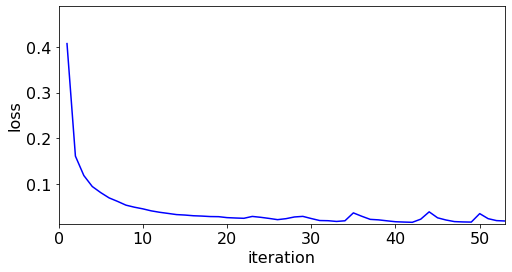

In [10]:
plotLoss(mlp)